<a href="https://colab.research.google.com/github/gkteco/fastai-pytorch-walkthroughs/blob/main/wholelot_of_deeplearning_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
import pandas as pd
# the goal of this first experiment is to demonstrate multi label image classification

# downloading the PASCAL dataset and construct a dataframe from it
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/"train.csv")
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
# constructing a DataBlock

from torch.utils.data import Dataset, DataLoader
from fastai.vision.data import Datasets, DataLoaders
# Note on Pytorch's Dataset and DataLoader and Fastai's Datasets and DataLoaders

# PyTorch's Dataset:
#   a collection that returns a tuple of your independaent and dependent variable for a single item

# PyTorch's DataLoaders:
#   an iterator that provides a stream of mini-batches, where each mini-batch is a
#   tuple of batch of independent variables and a batch of dependent variables

# Fastai's Datasets:
#   An iterator that contains a training Dataset and a validation Dataset

# Fastai's DataLoaders:
#   an object that contains a training DataLoader and a validation DataLoader


dblock = DataBlock()
dsets = dblock.datasets(df)
dsets.train[0] # this returns the first row in our training set. By default this is a tuple of (x, y)

(fname                         004047.jpg
 labels      chair diningtable cat person
 is_valid                            True
 Name: 2043, dtype: object,
 fname                         004047.jpg
 labels      chair diningtable cat person
 is_valid                            True
 Name: 2043, dtype: object)

In [ ]:
type(dsets)

fastai.data.core.Datasets

In [ ]:
# the above example is incorrect. We need to tell Datasets how to grab the correct
# (x,y) for each item in the dataframe
def get_x(x): return path/"train"/x["fname"]
def get_y(x): return x["labels"].split()

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/008019.jpg'),
 ['horse', 'person', 'car'])

In [ ]:
# for us to now open up the image, we could write a datacollator that performs
# this transform. However, we can tell fastai to do this for us using their type system
import numpy as np

dblock = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 0.]))

TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
                     0., 0., 0., 0., 0.])


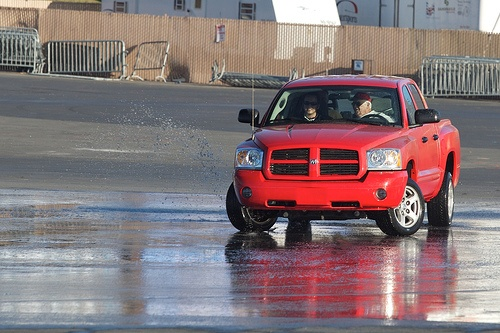

In [ ]:
from PIL import Image

exmp_img, exmp_label = dsets.train[0]
print(exmp_label)
exmp_img # since the ImageBlock tells the DataBlock to process the image by reading the path we pass to it, exmp_img is a pillow image we can view

In [ ]:
# Now let's take the labels we got in our examples and grab the label from our vocab
idxs = torch.where(exmp_label == 1)[0]
dsets.train.vocab[idxs]

(#2) ['car','person']

In [ ]:
# How did we do that? How did we pass a one-hot encoded vector
# (1 at the position in the vocab for all labels present in the image and 0's everywhere else)
# Where did we even get the one-hot encoded vector in the first place?

# Let's unpack what just happened. The block type MultiCategoryBlock told Fastai's DataBlock
# to encode the set of labels into a vocab and use the position of those labels for our
# one hot encoded vector.

# For exmple, let's spell out how we got the vocab.
# using python builtin funcitions and list concatenation we take all of the labels
# split them on white space, concatenate them, sort them, and build a set
# If this code confuses you, i'd reccomend inserting a few code blocks your self
# and bulding up the example from scratch.
# We now have our vocab!
vocab = set(sorted(sum([i.split() for i in df["labels"].tolist()], [])))
vocab

{'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor'}

In [ ]:
# MultiCategory block returns to us a one-hot encoded value

# Lets create a dictionary for use to lookup indexes into our labels and from
# labels to indexes
label2id = {v:k for k, v in enumerate(vocab)}
id2label = {k:v for v, k in label2id.items()}

# here is our labels
label = ["motorbike", "person"]

# let's construct our one hot tensor
one_hot = torch.zeros(len(vocab))
idxs = [label2id[i] for i in label]
one_hot[idxs] = 1 if len(idxs) > 0 else 0
print(one_hot)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])


In [ ]:
# now that we have a one hot tensore, we can apply the same function as above
# to mask out our dictionary and get the original labels. In this case
# motorbike and person

encoded_idxs = torch.where(one_hot == 1)[0]
decoded_labels = [id2label[i.item()] for i in list(encoded_idxs)]
decoded_labels

['motorbike', 'person']

In [ ]:
# Now we should have a good idea of the computaional trick of encoding labels
# as a one-hot vector and using it to look up the indexes in a vocab. This
# is a very useful concept in machine learning as it lets us encode human readable
# values such as strings into a numerical representation
# which we can use to train a nueral network

# let's get back to developing our datablock. Up to this point we have ignored
# the column that tells us if the data belongs to a training or validation set
# We also need to make sure that we apply a prepocessing transform that will
# make all of the images the same size when we turn our dataset into a dataloader
# GPUs like to process tensors of the same size. Since our training will take
# place on a GPU, let's fix our DataBlock and add a item_tfms (item transform)

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35)
)
dls = dblock.dataloaders(df) # instead of calling datasets we call dataloaderfs

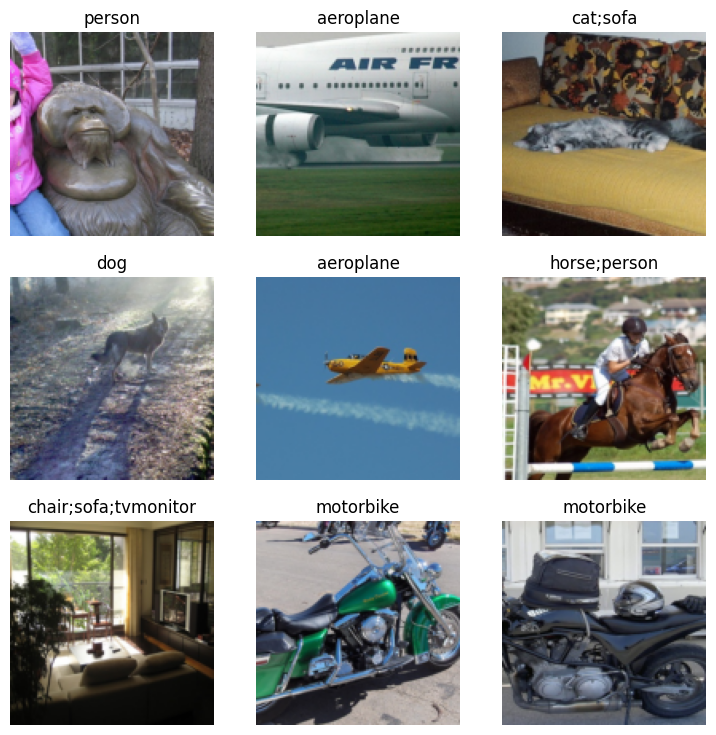

In [ ]:
dls.show_batch()

In [ ]:
# Now that the dataloaders object is ready, we can now train a model. We need a
# loss function.

learn = vision_learner(dls, resnet18)

# Since Learner is a class that inherits from PyTorch's nn.Module we can treat
# the learner as a function and call it to get activations. Let's inspect our
# models activations to ensure we have the right loss function for this
# use case.
x, y = dls.train.one_batch()

# this returns a single batch where the
# size is x.shape = (batch_size, channel, width, height)
# y.shape = (batch_size, len(vocab)). Let's validate this.
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [ ]:
# Now let's call the model to get activations we can inspect

activs = learn.model(x) # (batch_size, channel, width, height) --> (batch_size, len(vocab))

# Fastai is smart enough to tell our model what the output shape should look like.
activs.shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
activs[0]

TensorImage([-0.6339, -0.4666, -2.0998, -0.9729, -1.1917,  0.0371,  2.8917,
             -0.7177, -3.9543, -1.5098, -0.3335,  2.9998, -3.9575, -2.5348,
              1.7103, -1.3027,  0.7074, -1.3417,  0.4959,  1.1103],
            grad_fn=<AliasBackward0>)

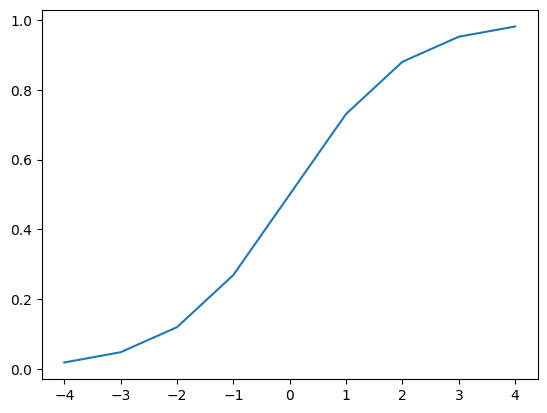

In [ ]:
import matplotlib.pyplot as plt
# Now let's define a loss function. Before we define a function let's walk through
# all of the intermediate outputs of each step. But before we do that let's
# do a deep dive on cross entropy loss.

# for a classification model (where a model needs to output one label per example)
# we can use the softmax function. Softmax is similar to the sigmoid function

x = torch.arange(9) - 4
y = torch.sigmoid(x)
plt.plot(x, y)

In [ ]:
# to get understand softmax (and cross entropy) we need to understand
# what the objective is of the model. If we have multiple categories
# we need a prediction (probabilty) for each one of these categories
# let's create an example.

acts = torch.randn((6, 2)) * 2 # random numbers with an std of 2 with a shape (6,2)
acts

tensor([[ 2.2417, -1.1701],
        [-3.0831,  2.4483],
        [ 0.6712, -0.3926],
        [ 0.7388,  1.0882],
        [ 0.7616,  1.4107],
        [ 0.9119, -2.3434]])

In [ ]:
# what do these activations really mean? Well, they can be considered the
# relative confidence of the model in both of our sythetic categories.

# in the binary case (we have two labels) and we where building a binary classifier
# we could encode the values as acts[:, 0] (the first column) being a no and
# acts[:, 1] (the second column) being a yes! Now if we were building a classifier
# such as "is_present" then we could just take the difference between the first
# and second columns. This could be interpreted as our raw confidence scores
# for whether or not something is "present".
print((acts[:, 1] - acts[:, 0]))

# now we can chuck our predicitons through a sigmoid
print((acts[:,1] - acts[:, 0]).sigmoid())

# this is not a trained network and for our purpose it does not matter.
# what matters is the which one is more and by how much. This is something that
# will be learned by the network. We evectually will train the network (through back prop)
# to predict higher values in the right category.

tensor([-3.4118,  5.5314, -1.0637,  0.3494,  0.6491, -3.2553])
tensor([0.0319, 0.9961, 0.2566, 0.5865, 0.6568, 0.0371])


In [ ]:
# sigmoid works great in the binary case however we need to generalize this more
# so that it can work on more than two categories. We can do this with softmax.

def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

# let's see what our softmax function returns for our activations
# we can see that we get the same values in our "is present" column as we did
# in our above example and 1 minus that value in the "not present" columns.
# This generalize to more than two categories. Softmax is the mulit-category equivalent
# of sigmoid.
sm_acts = softmax(acts)
print(sm_acts)

# further more we can see that if we sum the row everything adds up to 1
print(sm_acts.sum(dim=1))

tensor([[0.9681, 0.0319],
        [0.0039, 0.9961],
        [0.7434, 0.2566],
        [0.4135, 0.5865],
        [0.3432, 0.6568],
        [0.9629, 0.0371]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:
# as you can see softmax has a nice property of every category prediction adding up to 1
# we constructed the softmax with the exp which will amplify larger values (exponetially)

torch.exp(acts)

# intuitivly we can view softmax as really wanting to choose a category, amplifiying
# slightly larger values closer to 1 and the rest closer to zero

tensor([[ 9.4092,  0.3103],
        [ 0.0458, 11.5690],
        [ 1.9565,  0.6753],
        [ 2.0934,  2.9690],
        [ 2.1417,  4.0988],
        [ 2.4891,  0.0960]])

In [ ]:
# softmax is the first part of cross entropy. The next is log likelihood
# for our sythentic example let's define labels

targ = torch.tensor([0,1,0,1,1,0])
print(sm_acts)
print(targ)

tensor([[0.9681, 0.0319],
        [0.0039, 0.9961],
        [0.7434, 0.2566],
        [0.4135, 0.5865],
        [0.3432, 0.6568],
        [0.9629, 0.0371]])
tensor([0, 1, 0, 1, 1, 0])


In [ ]:
import torch.nn.functional as F
# now that we have our predictions and labels
# We can use tensor indexing to look up the correct
# label and negate the value. This is equivalent to the
# PyTorch function nll_loss. Beware this function
# does not take the log. It assumes you've already taken the log.
idx = range(6)
print(-sm_acts[idx, targ])
print(F.nll_loss(sm_acts, targ, reduction='none'))

tensor([-0.9681, -0.9961, -0.7434, -0.5865, -0.6568, -0.9629])
tensor([-0.9681, -0.9961, -0.7434, -0.5865, -0.6568, -0.9629])


In [ ]:
# when we first take the softmax and then the log likelihood of that, that combination is called cross-entropy
# here is a more spelled our version of this since F.nll_loss does not take the log
print(F.nll_loss(torch.log(sm_acts), targ, reduction="none"))
print(F.cross_entropy(acts, targ, reduction="none"))

# we can see that this is equivalent.

tensor([0.0324, 0.0040, 0.2965, 0.5336, 0.4204, 0.0378])
tensor([0.0324, 0.0040, 0.2965, 0.5336, 0.4204, 0.0378])


In [ ]:
# now let's move on to binary cross entropy
# the motivation is that with traditional cross entropy we've seen that
# the funciton pushes all other categories down while maximizing one category
# in the case of our multiple classificaiton where one input could yeild
# several or none labels the cross entropy will not work. Going back to our
# original example.

inputs, targets = activs[0].as_subclass(Tensor), y[0].as_subclass(Tensor) # grab one row in our activations

# at first the fucntion for binary cross entorpy can seem counter intuitive so let's
# walk through each intermidiate representation.

def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [ ]:
# First, we scale the inputs to be between 0 and 1 like before with sigmoid
inputs.sigmoid()

tensor([0.3936, 0.3574, 0.0328, 0.6809, 0.0734, 0.7780, 0.4335, 0.5773, 0.9544,
        0.6974, 0.2265, 0.9849, 0.4671, 0.0291, 0.9056, 0.8198, 0.9144, 0.9095,
        0.1653, 0.0096], grad_fn=<SigmoidBackward0>)

In [ ]:
# Now comparing the scaled inputs and are tagets....
inputs.sigmoid(), targets

(tensor([0.3936, 0.3574, 0.0328, 0.6809, 0.0734, 0.7780, 0.4335, 0.5773, 0.9544,
         0.6974, 0.2265, 0.9849, 0.4671, 0.0291, 0.9056, 0.8198, 0.9144, 0.9095,
         0.1653, 0.0096], grad_fn=<SigmoidBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
# Now for the part that (at least to me) seems counter intuitive
torch.where(targets==1, 1-inputs, inputs)

# Why 1-inputs when targets == 1? Well the answer is that since this is a
# generalized binary classification problem we need to encode the difference
# between a 0 and a 1. This is where the 1-inputs comes in. This is just saying that
# what ever the model outputs, maximize 1-inputs (in this case 1).
# Think about it for a little and you'll start to get it. Intuitivly this can
# be arbitrary, we are just saying to the model that
# "hey, where targets==1 output something different than the other outputs"

# Then we take the 1 log likleyhood.
inputs = inputs.sigmoid()
-torch.where(targets==1, 1-inputs, inputs).log().mean() # and here is our loss

tensor(0.5146, grad_fn=<NegBackward0>)

In [ ]:
# Thankfully, after you grok that, you won't need to think much of it anymore
# because fast ai is smart enought to know, based off of the Type system of DataBlocks
# that for a MultiLabelClassificaitonBlock you'll need BCEWithLogitsLoss for your loss function.
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(inputs, targets)
loss

tensor(1.0204, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
from functools import partial
# Now that we have a loss function, we need a metric to evaluate our model

def accuracy_multi(inputs, targets, thresh=0.5, sigmoid=True):
  if sigmoid: inputs = inputs.sigmoid()
  return ((inputs>thresh) == targets.bool()).float().mean()

# We are brinign partial into the namespace to "partialy apply" the function to
# new values of thresh to make new accuracy functions on the fly that we can
# pass to our learner.

In [ ]:
# Now for the best part. Let's train the model.

learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.3))
learn.model.to("cuda")

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [ ]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.901618,0.637084,0.390569,00:24
1,0.630434,0.230989,0.874251,00:26
2,0.292312,0.116565,0.955539,00:31


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.123561,0.100072,0.961028,00:37
1,0.106877,0.093029,0.965719,00:31
2,0.089863,0.088878,0.966816,00:26


In [ ]:
# We are getting some pretty good loss/accuracy. We picked 0.3 as our threshold
# Let's make sure we are picking the right threshold.

preds, targs = learn.get_preds()
preds.shape, targs.shape

(torch.Size([1002, 20]), torch.Size([1002, 20]))

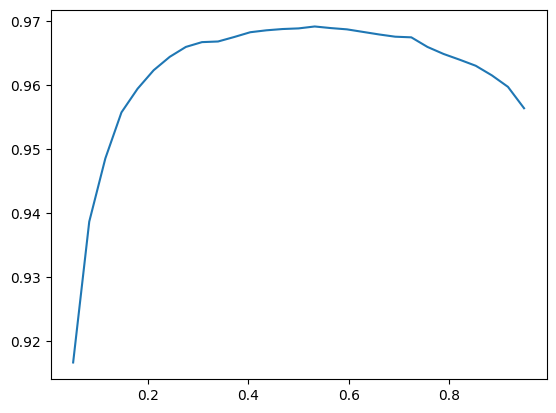

In [ ]:
# This could be looked at as over fitting over the training set. In reality
# it's good to plot these hyperparameter selections and be sure that you *arent*
# in this case, the curve is smooth and it does not apear to be us choosing an
# outlier that is fitting our training set. This means that we are safe to do this.

xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [ ]:
from fastai.vision.all import *
import numpy as np
import torch
import pandas as pd
# On to the next experiment. Image regression. We will move faster, but the pattern
# will remain the same. Assemble a DataBlock, create a DataLoaders object,
# instantiate a Learner object, and train the model.

path = untar_data(URLs.BIWI_HEAD_POSE)
path

Path('/root/.fastai/data/biwi_head_pose')

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/03/frame_00263_pose.txt')

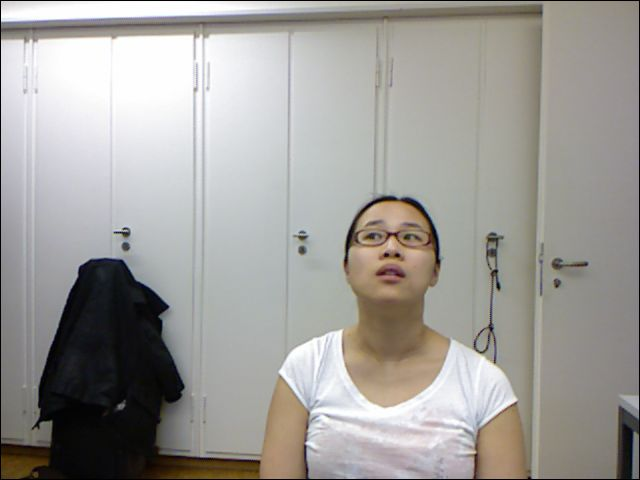

In [ ]:
Image.open(img_files[0])

In [ ]:
# This will be used as our get_y function

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

get_ctr(img_files[0])

tensor([397.2797, 247.6128])

In [ ]:
# Now let's consturct our DataBlock. Much stays the same, what changes is our
# block types which tells Fastai which loss function to use and how to prepare
# the data.
biwi = DataBlock(
    blocks=[ImageBlock, PointBlock],
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=="13"),
    batch_tfms=[*aug_transforms(size=(240, 320)), Normalize.from_stats(*imagenet_stats)]
)

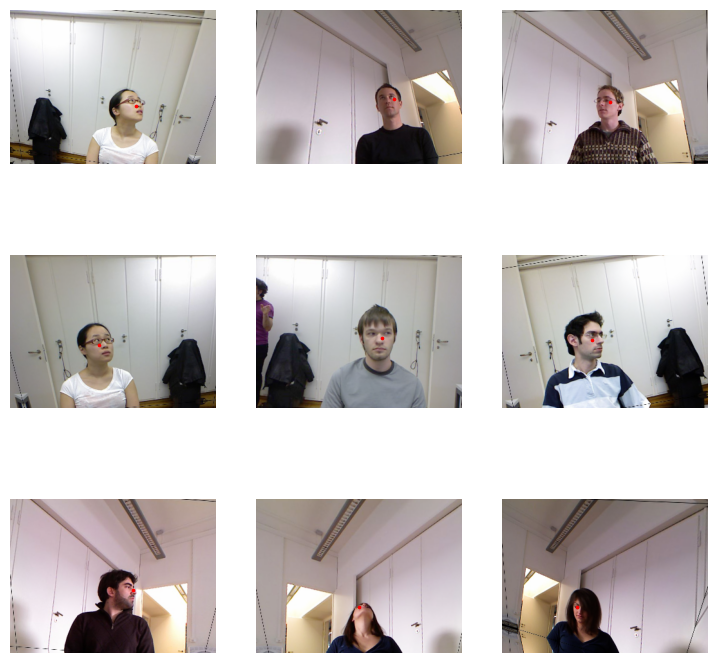

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch()

In [ ]:
# Training the model

learn = vision_learner(dls, resnet50, y_range=(-1, 1))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


SuggestedLRs(valley=0.00013182566908653826)

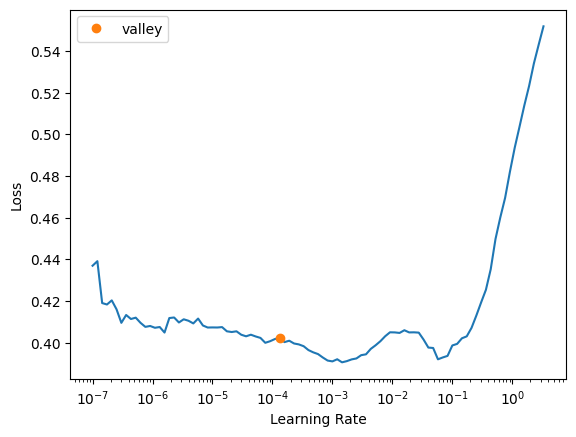

In [ ]:
# now let's find the right learning rate to use for our model
learn.lr_find()

In [ ]:
lr = 1e-3
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.236246,0.051904,03:23


epoch,train_loss,valid_loss,time
0,0.081110,0.004206,04:16
1,0.020624,0.002970,04:24
2,0.012287,0.000817,04:16


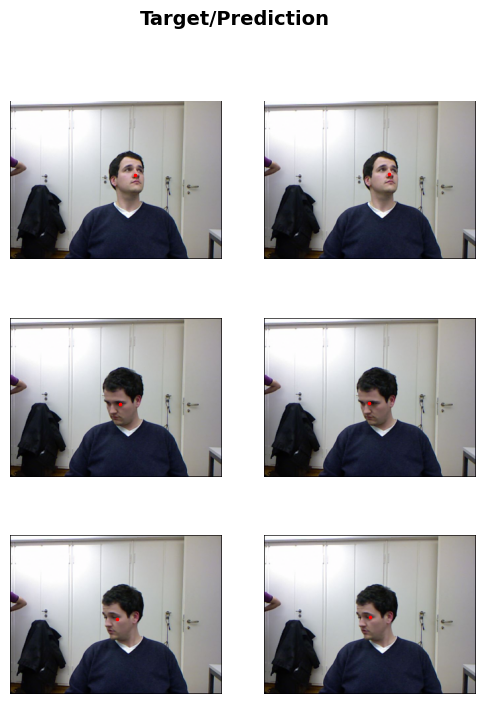

In [ ]:
# show our results

learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

In [ ]:
# As we've seen, what seemed like very different problems (binary classificaiton,
# muli label classification, and image regression) they all shared a lot of the
# same patterns. Given this it's safe to generalize that models are defined
# with their data and loss function. So, as a general rule of thumb
# CrossEntropyLoss - for single label classificaiton
# BinaryCrossEntropyLoss - for muli label classification
# MSELoss - for regression

In [ ]:
# Traning a state of the art model

# again, we will see the same pattern as before
# prepare the data
# consturct a DataBlock
# *optional* declare a loss function
# instantiate a DataLoaders object
# instantiate a model
# define a metric to evaluate the model
# train the model


# Here we are using Imagenettee as our fill in for ImageNet.
# While we are on consumer grade hardware or just simply experimenting we
# should prioratize what is important in a DL development/research project.
# We should optimize for faster iterations and prove out differenct experiments
# at different scales. Try things, test, try more things. The training times on
# large datasets can be a bottle neck for iteration. To solve for this we must
# do our best to find represenative subsets of our data so that the datasets are not
# too big where we spend majority of valuable experimentation time waiting on
# model training. Furthermore, it is also important since you'll be using a subset
# of the larger target dataset that you define what you want to measure.

# Here we will be training up a SOTA model on a subset of ImageNet called ImageNette.
# We will use this subset to explore and iterate on different research ideas to improve the model
from fastai.vision.all import *

path = untar_data(URLs.IMAGENETTE)
path

Path('/root/.fastai/data/imagenette2')

In [ ]:
dblock = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = dblock.dataloaders(path, bs=64)

In [ ]:
x,y = dls.train.one_batch()
# x.shape: (batch_size, channels, width, height)
# y.shape: (batchsize)
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

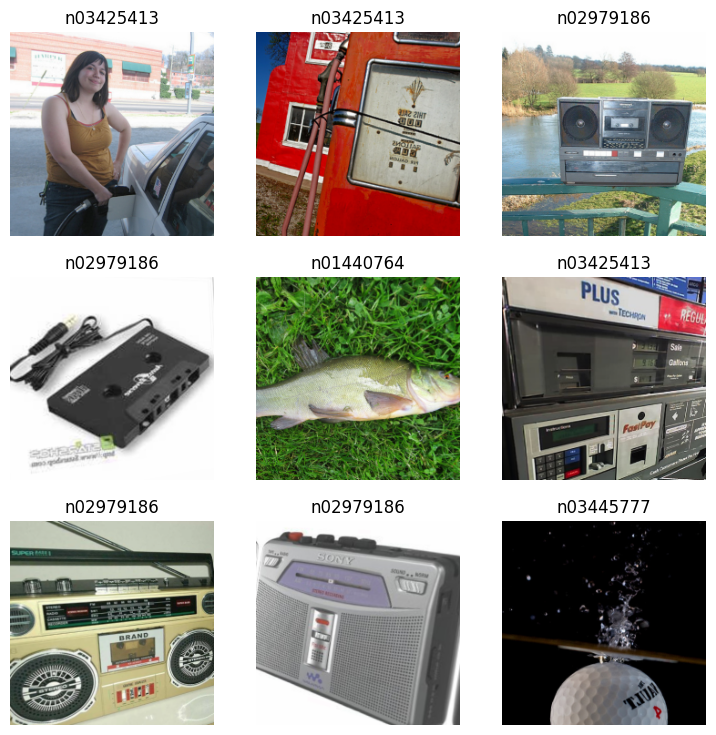

In [ ]:
dls.show_batch()

In [ ]:
# this time, instead of using vision_learner let's instandiate our own Learner
# object directly

model = xresnet50(n_out=len(dls.train.vocab)).to("cuda")
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.544793,1.587538,0.483570,02:36
1,1.201305,2.422825,0.387229,03:23
2,0.946137,0.999424,0.680732,03:34
3,0.771407,0.668399,0.794623,03:15
4,0.633441,0.613147,0.814414,03:13


In [ ]:
# Now that we have a base line, let's try to improve the model

# our first stop in improving our model is normalization
# normalization means that the input data is "normalized",
# that is the data having a mean of 0 and a std of 1

# Let's first inspect the data and see what our original data's mean and std is.
x, y = dls.one_batch()
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])

(TensorImage([0.4502, 0.4398, 0.4299], device='cuda:0'),
 TensorImage([0.2771, 0.2701, 0.2857], device='cuda:0'))

In [ ]:
# we can tell our datablock to normalize our data for each item in the dataset
# let's redefine our datablock

dblock = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(path)

In [ ]:
# batch_tfms will be done per batch on the GPU. This will make this operation
# faster and also act as a regulization technique since the data will be normalized
# per batch of 64 items instead of across the whole dataset. This technique is called
# batch normalization.

# let's check our batch means and std now
x, y = dls.one_batch()
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])

(TensorImage([0.0448, 0.1536, 0.2504], device='cuda:0'),
 TensorImage([1.2614, 1.2908, 1.3808], device='cuda:0'))

In [ ]:
# Did this have an affect on the model? Well, let's try it!

model = xresnet50(n_out=len(dls.train.vocab))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.563552,2.304786,0.371546,03:20
1,1.206370,1.452861,0.537715,03:23
2,0.963587,1.260659,0.594473,03:31
3,0.760955,0.666866,0.788275,03:02
4,0.655507,0.605556,0.815161,02:55


In [ ]:
# note that normalization become extremly important when working with pretrained models
# the models were trained on a specific set of data. If you don't follow those rules
# you'll be "fine tuning" a model on a type of data format it has not yet seen before.
# this will damage the model and yield un favorable results. When models are distributed
# typically the normalization stats are also distributed. Fastai helps here with
# providing the right nomalizaiton functio for your model in vision_learner. However
# if this is a custom model, you'll need to tell the Datablock how to normalize the data.


# On to the next optimization, Progressive Resizing

# When Fastai and it's team of student won the DAWNBench competition, one
# of the most important innovations was something called Progressive Resizing and
# it's very simple! Start with small images and progressivly make the images larger
# as the model trains. For this we will need to write a function that can let us
# make data loaders on the fly.

def mk_dls(bs, size):
  dblock = DataBlock(
      blocks=[ImageBlock, CategoryBlock],
      get_items=get_image_files,
      get_y=parent_label,
      item_tfms=Resize(460),
      batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                  Normalize.from_stats(*imagenet_stats)]
  )
  return dblock.dataloaders(path, bs=bs)

In [ ]:
# Start training the model with images size 128, 128
dls = mk_dls(128, 128)
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.605504,2.120126,0.416355,02:51
1,1.220847,1.882638,0.485063,02:46
2,0.966295,0.949912,0.706871,02:35
3,0.782325,0.794553,0.753547,02:46


In [ ]:
# Now let's hot swap the dataloader with the new direction of changing the
# batch size and training on larger images
learn.dls = mk_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.430140,1.419150,0.552651,02:43


epoch,train_loss,valid_loss,accuracy,time
0,1.257823,1.250560,0.637043,02:42
1,1.249941,0.981602,0.677745,02:44
2,1.177747,0.820928,0.735624,02:48
3,1.087994,0.587285,0.827110,02:45
4,1.050134,0.550313,0.842046,02:43


In [ ]:
# Now on to two more optimization techniques. TTA and Mixup

# TTA: during inference or validations, create multiple versions of each image using data augmentation and then take
# the average or maximum of the predictions for each augmented version of the image

# As a default fastai's tta method will take the dls.validation and perform TTA
# We can test to see if we get a boost in accuracy.
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.7782)

In [ ]:
# Now it's time to see how we can use a data augmentaion technique to train our
# model and attempt to boost performance. The technique is called mixup

# Mixup works as the following routine
# For each image in the dataset:
#   1) Select another image from you dataset at random
#   2) Pick a wight at random
#   3) Take a weighed average of the selected image with your image
#   4) Take a weighed average of the image's labels with your image's labels

# Intuitivly this will will "mix up" the training set and make the model
# be more sensitive to how it is predicting images. Let's train the model using
# mixup!

model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.897087,1.847168,0.444361,02:10
1,1.667452,1.373277,0.570575,03:03
2,1.453566,1.056729,0.665795,02:11
3,1.313632,0.929324,0.712099,02:10
4,1.219457,0.787190,0.764376,02:12


In [ ]:
# the last optimization technique we will use is called label smoothing.
# Intuitivly when we are working with one hot encoded computed loss we are working
# with 0's and 1's and cross entropy will push our predictions closer to 1 or 0.
# This can encourage the model to over fit. Thus, we can smooth out the labels to
# very close to 0s and very close to 1s. Fastai makes this easy.

model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.782654,1.948216,0.427931,02:09
1,1.505264,1.550346,0.574309,02:11
2,1.290381,1.266588,0.700149,02:09
3,1.153736,1.101411,0.776699,02:18
4,1.060947,1.063113,0.796117,02:13
